# Importing the Libraries

In [0]:
import os
import re
import cv2
import torch
import torchvision
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from TrainDataset import TrainDataset
from TestDataset import TestDataset
from model import ReconNet
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt
import matplotlib.pyplot as pyplot
%matplotlib inline

# Handling Google Drive Authentication

In [2]:
!pip install PyDrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
fileId = drive.CreateFile({'id': '1gr5QL5VKjx5NjJExsEf86tfBDbLUyg8X'})  #DRIVE_FILE_ID
print(fileId['title'])  # folder_data.zip
fileId.GetContentFile('images.zip')  # Save Drive file as a local file

BSDS200.zip


In [0]:
# Unzip Images
!unzip images.zip -d ./

# Plotting Sample Images

In [0]:
path = 'BSDS200'

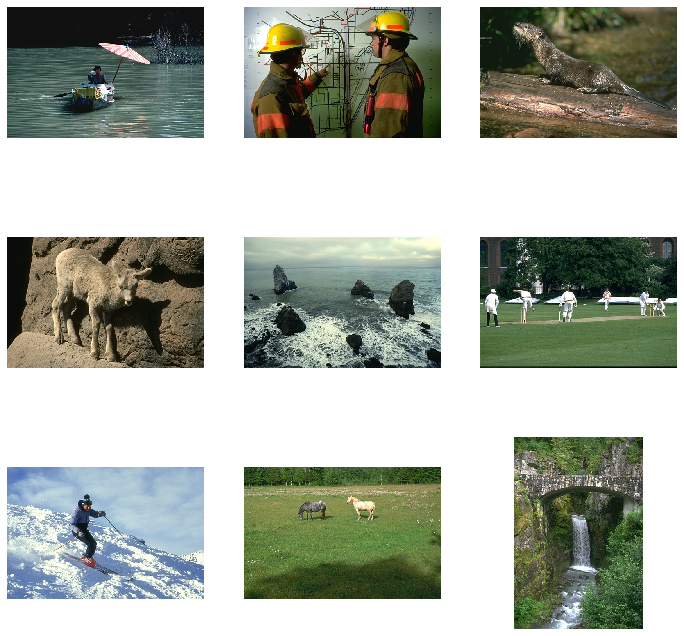

In [7]:
fig, axes = plt.subplots(3, 3, figsize = (12,12))
for row in axes:
  for axe in row:
      index = np.random.randint(len(os.listdir(path)))
      img_name = os.listdir(path)[index]
      img = plt.imread(os.path.join(path, img_name))
      # lbl = img_name.rsplit('_',1)[0]
      axe.imshow(img)
      # axe.set_title(lbl)
      axe.set_axis_off()

# Importing the Phi measurement matrix

In [8]:
from google.colab import files
uploaded = files.upload()

Saving phi_0_01_1089.mat to phi_0_01_1089.mat
Saving phi_0_04_1089.mat to phi_0_04_1089.mat
Saving phi_0_10_1089.mat to phi_0_10_1089.mat
Saving phi_0_25_1089.mat to phi_0_25_1089.mat


In [0]:
import scipy.io
mat = scipy.io.loadmat('phi_0_25_1089.mat')['phi']

In [10]:
mat = torch.from_numpy(mat)
mat

tensor([[ 0.0111, -0.0043,  0.0032,  ..., -0.0165, -0.0210,  0.0138],
        [-0.0101, -0.0300,  0.0652,  ...,  0.0607, -0.0188,  0.0223],
        [ 0.0198,  0.0161, -0.0134,  ..., -0.0073, -0.0080,  0.0194],
        ...,
        [ 0.0169,  0.0153,  0.0450,  ...,  0.0235, -0.0127,  0.0184],
        [ 0.0019, -0.0256, -0.0796,  ..., -0.0441, -0.0120,  0.0093],
        [-0.0087, -0.0158, -0.0167,  ..., -0.0138, -0.0184,  0.0200]],
       dtype=torch.float64)

In [12]:
mat.size()

torch.Size([272, 1089])

DataLoader

In [18]:
files.upload()

Saving TestDataset.py to TestDataset.py
Saving TrainDataset.py to TrainDataset (1).py


{'TestDataset.py': b'import torch\r\nimport torchvision\r\nimport numpy as np\r\nfrom torchvision import transforms\r\nfrom torch.utils.data import Dataset\r\n\r\n\r\nclass TestDataset(Dataset):\r\n  def __init__(self,image_blocks,mat,transform = None,phi=0.25):\r\n    self.image_blocks = image_blocks\r\n    self.transform = transform\r\n    self.phi = phi\r\n    self.mat = mat\r\n\r\n  def __len__(self):\r\n    return len(self.image_blocks)\r\n\r\n  def __getitem__(self,idx):\r\n    image_block = self.image_blocks[idx]\r\n    label = image_block\r\n    if self.transform is not None:\r\n      image_block = self.transform(image_block)\r\n      label = self.transform(label)\r\n    image_block = image_block.view(33*33)\r\n    label = label.view(33*33)\r\n    image_block = image_block.double()\r\n    label = label.double()\r\n    with torch.no_grad():\r\n      image_block = torch.matmul(self.mat,image_block)\r\n\r\n    return image_block,label',
 'TrainDataset.py': b'import torch\r\nimport

In [0]:
transformations = transforms.Compose([transforms.ToTensor()])
train_data = TrainDataset(path,mat,transformations,0.25)

In [21]:
train_data.__len__()

138600

In [22]:
train_data.__getitem__(0)

(tensor([ 1.6857e-02,  2.5345e-01,  3.0128e-01,  8.8402e-01,  5.8236e-01,
         -1.5307e+00, -2.0804e+00,  3.1739e-02,  3.5859e-01, -1.0503e+00,
          6.7788e-01,  3.2275e-01,  3.7289e-01,  1.5180e+00,  6.1930e-01,
         -4.1410e-01, -1.1311e+00, -1.1335e+00,  5.3653e-01, -4.9381e-02,
         -2.0186e-01,  4.1988e-01, -9.4356e-01,  5.9907e-02, -1.6643e-01,
          1.0968e+00,  7.6227e-01, -1.6863e+00, -5.3465e-01, -8.8336e-02,
          7.9367e-01, -5.0237e-01, -7.3089e-01, -1.6550e+00, -8.1831e-01,
         -1.0932e+00, -2.7497e-03,  9.1683e-01, -1.2281e+00, -9.3788e-01,
          4.5723e-01, -2.6912e-01,  7.6917e-01, -3.4612e-01,  1.0437e-01,
          2.7086e-01,  9.9194e-01, -7.0852e-01, -3.5847e-01, -1.2063e-01,
         -7.5869e-01,  2.3413e-01, -1.3851e+00, -6.3711e-01, -6.7537e-01,
          3.1162e-01,  2.5616e-01,  5.8693e-02,  3.5554e-01,  9.6886e-01,
         -3.4005e-01,  1.1677e+00, -1.3321e-01,  6.5095e-02,  3.1680e-01,
          8.1570e-01,  3.8284e-01,  1.

In [27]:
train_data.__getitem__(0)[0].size()

torch.Size([272])

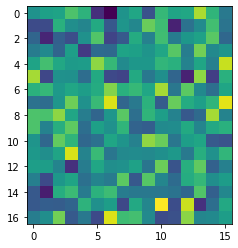

In [33]:
plt.imshow(train_data.__getitem__(0)[0].view(17,16))

In [0]:
train_dl = DataLoader(train_data,batch_size=128)

In [35]:
print("No of Batches -",len(train_dl))

No of Batches - 1083


In [36]:
train_iter = iter(train_dl)
print(type(train_iter))

images , labels = train_iter.next()
print('Images shape on batch size = {}'.format(images.size()))
print('Labels shape on batch size = {}'.format(labels.size()))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
Images shape on batch size = torch.Size([128, 272])
Labels shape on batch size = torch.Size([128, 1089])


# ReconNet model

In [39]:
files.upload()

Saving model.py to model.py


{'model.py': b'import torch\r\nimport torchvision\r\nimport torch.nn as nn\r\nimport torch.nn.functional as F\r\nfrom torch.autograd import Variable\r\n\r\n\r\n\r\nclass ReconNet(nn.Module):\r\n  def __init__(self,measurement_rate=0.25):\r\n    super(ReconNet,self).__init__()\r\n\r\n    self.measurement_rate = measurement_rate\r\n    self.fc1 = nn.Linear(int(self.measurement_rate*1089),1089)\r\n    nn.init.normal_(self.fc1.weight, mean=0, std=0.1)\r\n    self.conv1 = nn.Conv2d(1,64,11,1,padding=5)\r\n    nn.init.normal_(self.conv1.weight, mean=0, std=0.1)\r\n    self.conv2 = nn.Conv2d(64,32,1,1,padding=0)\r\n    nn.init.normal_(self.conv2.weight, mean=0, std=0.1)\r\n    self.conv3 = nn.Conv2d(32,1,7,1,padding=3)\r\n    nn.init.normal_(self.conv3.weight, mean=0, std=0.1)\r\n    self.conv4 = nn.Conv2d(1,64,11,1,padding=5)\r\n    nn.init.normal_(self.conv4.weight, mean=0, std=0.1)\r\n    self.conv5 = nn.Conv2d(64,32,1,1,padding=0)\r\n    nn.init.normal_(self.conv5.weight, mean=0, std=0.1)

In [37]:
# Checking for availability of GPU

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


In [0]:
model = ReconNet(measurement_rate=0.25)
model = model.cuda()

In [0]:
criterion = nn.MSELoss()
criterion = criterion.cuda()

In [0]:
# Adam Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

*Uncomment the following 2 blocks for training and saving the model*

In [0]:
# def train(model,criterion,optimizer,train_dl,num_epochs=100):
#   for epoch in range(num_epochs):
#     train_loss = []
#     model.train()
#     for inp, lbl in train_dl:
#       inp = inp.cuda()
#       lbl = lbl.cuda()
#       inp = inp.float()
#       lbl = lbl.float()

#       optimizer.zero_grad()
#       out = model(inp)
#       out = out.cuda()
#       out = out.view(lbl.size())
#       loss = criterion(out,lbl)
#       loss.backward()
#       optimizer.step()

#       train_loss.append(loss.item())

#     print('Epoch:',epoch+1, 'Training Loss:',np.mean(train_loss))


# train(model,criterion,optimizer,train_dl,50)

In [0]:
# torch.save(model.state_dict(), '/model_state.pth')

In [46]:
# Upload the saved model

files.upload()

Saving model_state.pth to model_state.pth


{'model_state.pth': b'\x80\x02\x8a\nl\xfc\x9cF\xf9 j\xa8P\x19.\x80\x02M\xe9\x03.\x80\x02}q\x00(X\x10\x00\x00\x00protocol_versionq\x01M\xe9\x03X\r\x00\x00\x00little_endianq\x02\x88X\n\x00\x00\x00type_sizesq\x03}q\x04(X\x05\x00\x00\x00shortq\x05K\x02X\x03\x00\x00\x00intq\x06K\x04X\x04\x00\x00\x00longq\x07K\x04uu.\x80\x02ccollections\nOrderedDict\nq\x00)Rq\x01(X\n\x00\x00\x00fc1.weightq\x02ctorch._utils\n_rebuild_tensor_v2\nq\x03((X\x07\x00\x00\x00storageq\x04ctorch\nFloatStorage\nq\x05X\n\x00\x00\x002552279424q\x06X\x06\x00\x00\x00cuda:0q\x07J\x10\x85\x04\x00Ntq\x08QK\x00MA\x04M\x10\x01\x86q\tM\x10\x01K\x01\x86q\n\x89h\x00)Rq\x0btq\x0cRq\rX\x08\x00\x00\x00fc1.biasq\x0eh\x03((h\x04h\x05X\x08\x00\x00\x0086883808q\x0fX\x06\x00\x00\x00cuda:0q\x10MA\x04Ntq\x11QK\x00MA\x04\x85q\x12K\x01\x85q\x13\x89h\x00)Rq\x14tq\x15Rq\x16X\x0c\x00\x00\x00conv1.weightq\x17h\x03((h\x04h\x05X\x08\x00\x00\x0086883712q\x18X\x06\x00\x00\x00cuda:0q\x19M@\x1eNtq\x1aQK\x00(K@K\x01K\x0bK\x0btq\x1b(KyKyK\x0bK\x01tq\x1c\

In [0]:
state_dict = torch.load('model_state.pth')

In [48]:
model.load_state_dict(state_dict)
model.eval()

ReconNet(
  (fc1): Linear(in_features=272, out_features=1089, bias=True)
  (conv1): Conv2d(1, 64, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(32, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (conv4): Conv2d(1, 64, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
  (conv5): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv6): Conv2d(32, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
)

# Reconstructing Test Image

In [50]:
# Upload test image

files.upload()

Saving test1.png to test1.png


{'test1.png': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01v\x00\x00\x00\xed\x08\x02\x00\x00\x00$\xea\xc9\x06\x00\x00\x00\x07tIME\x07\xe0\x04\x05\x12$,\xc4\\\x1d\x8b\x00\x00 \x00IDATx\x9c\\\xbc[\xaf,Iv\x1e\xf6\xadKDfV\xd5\xbe\x9e>}Nw\xcf\xa59\x9c\xe1\xf02CQ6(\x904a\xc12a>\xd8\x90)\xc10\xa0\x07\xc3\x0f\xf6\x1f2`\x18\x16l?\x18\x86\x1f,\x11 A\xca\x82i\x11\xa0-\xc3\xb2AS\xe4\x10#if83=\xcd\xee\x99\xees?\xfbV\x95\x99\x11\xb1\xd6\xf2C\xd4>\xddd\x1d\xa0\xb0O\xed\xdc\x91\x99Q\x11k}\xeb\xfb\xbe\x95t\xf5\xf4c\xf4W0\x11ED\x7fw\x02\x11\x91\x87\x99\x11\x91\x93\x03\xc7\x03\x04$"\x11\xe1\x1e@\x10\x91G\xebc\x10\xe4\xcd\x08\xfd\xdd`\xccLN\xc1\xc4\xcc\x008\x100V5\x0b"vw"\x00P:\x8e\x1fL\x02\n\xee\x83D\x10\x03\x88\x08\xee\xe7r\'"\x81D\x80\x88\x80 \x8e\x88\x10\xa1\x88\xe8\x97\xc1\xcc\x80\xcf\xf3\x8c\xf0\xcd\xb4%"0\x05\x13\x11\x01 \xa2\x08gf\x87\x01\x800Q\x10\xfc8\r@ \x00\xb0;(\x00\x80\x04\x9f\xbd\x1c\xfdj\x82\x88\x18\xde\x0f\x08\x00\x01\x8a\x08w\x10\x11\x058\x10\x11\xee\xee\x8e\x08\x02`f-\x9a{k\x16\x88\

In [65]:
test_img = plt.imread('test1.png')
test_img.shape

(237, 374, 3)

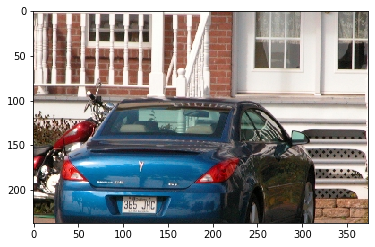

In [66]:
# Original Image
plt.imshow(test_img)

In [0]:
image_blocks = []
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2YCR_CB)
test_img = cv2.normalize(test_img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
test_img = test_img[:,:,0]
h,w = test_img.shape
stride = 14
filter_size = 33
h_n = ((h - filter_size) // stride) + 1
w_n = ((w - filter_size) // stride) + 1

for i in range(h_n):
  for j in range(w_n):
    blocks = test_img[i*stride:(i*stride)+filter_size, j*stride:(j*stride)+filter_size]
    image_blocks.append(blocks)

image_blocks = np.array(image_blocks)

In [68]:
image_blocks.shape

(375, 33, 33)

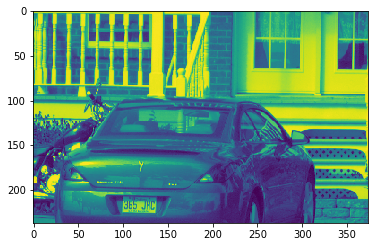

In [70]:
# Processed Image
plt.imshow(test_img)

# Save the image
from matplotlib import pyplot

pyplot.savefig('test_sample.png', bbox_inches='tight')

In [0]:
test_data = TestDataset(image_blocks,mat,transformations,0.25)

In [0]:
test_dl = DataLoader(test_data,1083)

In [73]:
# Model Outputa
inp,lbl = next(iter(test_dl))
inp = inp.cuda()
lbl = lbl.cuda()
inp = inp.float()
lbl = lbl.float()

out = model(inp)
out = out.cuda()
out = out.view(lbl.size())
loss = criterion(out,lbl)
print('Test Loss',loss.item())

Test Loss 0.006784736178815365


In [74]:
out = out.view(-1,33,33)
out.size()

torch.Size([375, 33, 33])

In [0]:
out = out.cpu()
out = out.detach().numpy()

In [0]:
# Reconstruct the image
h,w = test_img.shape
recon_img = np.zeros((h,w))

k = 0
for i in range(h_n):
  for j in range(w_n):
    recon_img[i*stride:(i*stride)+filter_size, j*stride:(j*stride)+filter_size] = out[k]
    k += 1

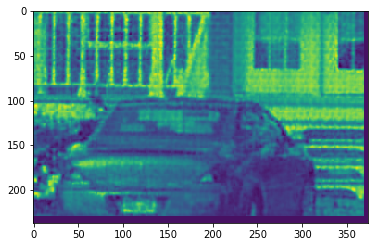

In [77]:
# Reconstructed Image
plt.imshow(recon_img)

# Save the image
from matplotlib import pyplot

pyplot.savefig('sample_result.png', bbox_inches='tight')